<a href="https://colab.research.google.com/github/ShivaShanmuganathan/Pneumonia_Detection_Inception_V3/blob/master/Transfer_Learning_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning

<br/>Using a Pretrained  Inception V3 Model to Apply Transfer Learning to Classify for Pneumonia.


Dataset - [Kaggle Pneumonia Dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

## Setting up the Colab Environment 

In [0]:
# Bare Bones 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np
import random

# Tensorflow and Keras 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Some utils 
from itertools import product
from functools import partial

# Mount the Drive if in Google Colaboratory
try:
    from google.colab import drive
except:
    pass

In [0]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
import pandas as pd
from tensorflow.python.keras.preprocessing import image


In [0]:
from numpy.random import seed
from tensorflow import set_random_seed

##Load the Dataset


<br/>The dataset is Downloaded directly from Kaggle to Colab. 

In [4]:
os.environ['KAGGLE_USERNAME'] = "shanshiva"
os.environ['KAGGLE_KEY'] = "xxxx"

seed(100)
set_random_seed(100)
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia #5 seconds

100% 2.29G/2.29G [00:21<00:00, 175MB/s]
100% 2.29G/2.29G [00:21<00:00, 116MB/s]
CPU times: user 261 ms, sys: 68.5 ms, total: 330 ms
Wall time: 27 s


In [5]:
%time !unzip chest-xray-pneumonia.zip #10 seconds

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [6]:
%time !unzip chest_xray.zip #27 seconds

unzip:  cannot find or open chest_xray.zip, chest_xray.zip.zip or chest_xray.zip.ZIP.
CPU times: user 31.3 ms, sys: 10.4 ms, total: 41.7 ms
Wall time: 3.69 s


In [0]:
#Point to the relevant directories
train_dir = "chest_xray/train/" #directories for training
validation_dir   = "chest_xray/val/" 

test_dir  = "chest_xray/test/" #directory for final model scoring


Let's see if we are able to display an image. 

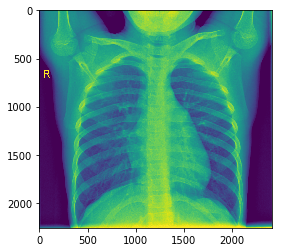

In [8]:
img = mpimg.imread(train_dir + '/NORMAL/IM-0666-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

Visualize a few more images

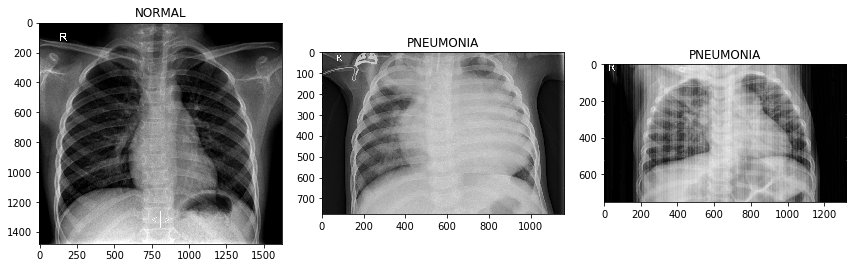

In [9]:
# Normal 
img_normal = plt.imread(f'{train_dir}NORMAL/IM-0764-0001.jpeg')
# Bacterial
img_penumonia_bacteria = plt.imread(f'{train_dir}PNEUMONIA/person5_bacteria_19.jpeg')
# Viral
img_penumonia_virus = plt.imread(f'{train_dir}PNEUMONIA/person1224_virus_2074.jpeg')

# Plot Configuration
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')
plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')
plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

## Building a Model using _Inception v3_
We will be doing transfer learning using the Inception V3 pretrained model. 

In [10]:
# The number of classes we are trying to classify are 2
# Normal or Pneumonia
NUM_CLASSES = 2

# Build the Model
def create_model(input_shape, num_classes):
  """
  Creates the image classifier model on top of a
  pretrained Inception v3.

  Parameters
  ----------
  input_shape : Tuple    
      Shape tuple for Inception v3
  
  num_classes : Integer
      The number of classes that the classifier is 
      going to classify

  Returns
  -------
  The tensorflow model.  
  """
  # We start with a blank slate
  K.clear_session()

  # Inception v3 is our base model
  base_model = InceptionV3(weights='imagenet', include_top=False,\
                           input_shape=input_shape)
  
  # Add our custom layers on top for classification
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  # We are using the base model only for feature extraction
  # So we make sure the layer weights don't change 
  for layer in base_model.layers:
    layer.trainable = False

  # The final predictions layer is going to be a dense layer
  # with Sigmoid activations - predicts only 'num_classes'    
  predictions = Dense(num_classes, activation='sigmoid')(x)
  # Instantiate the model 
  model = Model(inputs=base_model.inputs, outputs=predictions)

  return model


# Creat the model with Height & Width as 150 and 3 channels for Inception
# And we are going to predict only 2 classes in our case
model = create_model((150, 150, 3), NUM_CLASSES)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 4s 0us/step


In [11]:
# Training loss
training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
# Training Accuracy
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
# Test Loss 
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
# Test Accuracy 
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)

# Print model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Compile the model 

In [0]:
# We use the standard Adam Optimizer 
optimizer = Adam(lr=0.0001)

# Compile 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

## Feature Engineering 
Time to _augment_ our image dataset a little bit to ensure that we do not  
start _Overfitting_. 

In [0]:
def dir_file_count(directory):
  """
  Counts the total number of files in a directory. 

  Parameters
  ----------
  directory : String    
      The directory isnide which the function is going
      to count the number of files 
  
  Returns
  -------
  Total number of files present inside the 'directory'.  
  """
  return sum([len(files) for r, d, files in os.walk(directory)])

In [14]:
# Configuration parameters 
rescale = 1./255
target_size = (150, 150)
batch_size = 500
class_mode = 'categorical'

# Augment the Training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


## Train the Model
We are all set, it's time to train the model now!

<br/>We will be training for 50 epochs only as after a few hit and  
trials it becomes apparent that the model starts to overfit beyond that. 

In [16]:
# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=10,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

# Save the model after the training is complete
MODEL_FILE = 'pneumonia_iv3.hd5'
model.save(MODEL_FILE)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11/11 [==============================] - 99s 9s/step - loss: 0.6687 - acc: 0.6271 - val_loss: 1.4819 - val_acc: 0.5000
Epoch 2/10
11/11 [==============================] - 65s 6s/step - loss: 0.5927 - acc: 0.7429 - val_loss: 0.8342 - val_acc: 0.5000
Epoch 3/10
11/11 [==============================] - 74s 7s/step - loss: 0.5410 - acc: 0.7437 - val_loss: 1.0044 - val_acc: 0.5000
Epoch 4/10
11/11 [==============================] - 76s 7s/step - loss: 0.4788 - acc: 0.7458 - val_loss: 0.8135 - val_acc: 0.5000
Epoch 5/10
11/11 [==============================] - 74s 7s/step - loss: 0.4248 - acc: 0.7651 - val_loss: 0.7776 - val_acc: 0.5000
Epoch 6/10
11/11 [==============================] - 75s 7s/step - loss: 0.3672 - acc: 0.8183 - val_loss: 0.8739 - val_acc: 0.5625
Epoch 7/10
11/11 [==============================] - 76s 7s/step - loss: 0.3346 - acc: 0.8652 - val_loss: 0.9566 - val_acc: 0.6

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

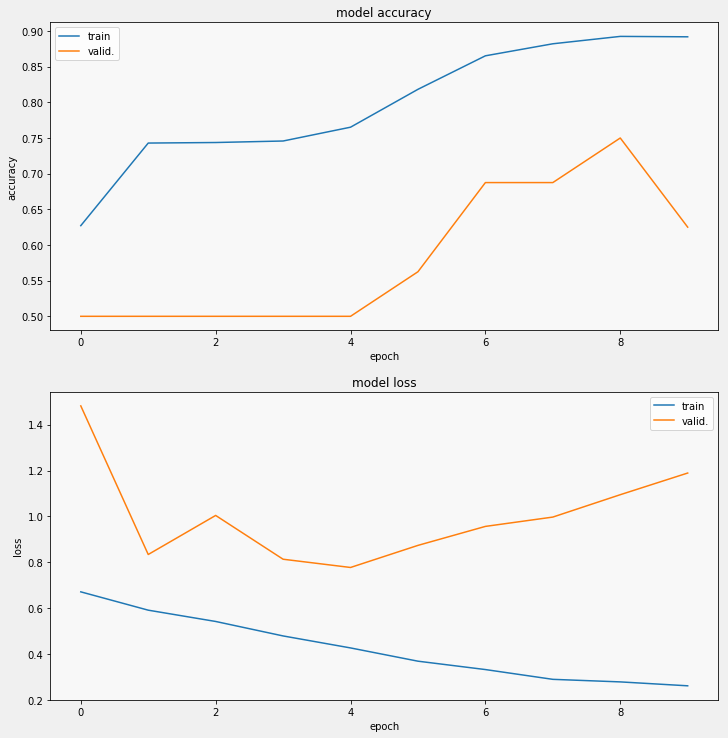

In [18]:
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Evaluate the Model 
Now that we have our trained model at hand, let's see how well it does on  
Training Set. 


In [19]:
# Load the Model 

model = tf.keras.models.load_model(MODEL_FILE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
# Run the model on Test Data 
result = model.evaluate_generator(test_generator, steps=len(test_generator),\
                                  verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 15s 15s/step - loss: 1.1303 - acc: 0.7051
Loss     : 1.13  
Accuracy : 70.51%


In [21]:
vl_score = model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.68      0.40      0.51       234
   Pneumonia       0.71      0.89      0.79       390

    accuracy                           0.71       624
   macro avg       0.70      0.64      0.65       624
weighted avg       0.70      0.71      0.68       624

AUC:  0.6444444444444444


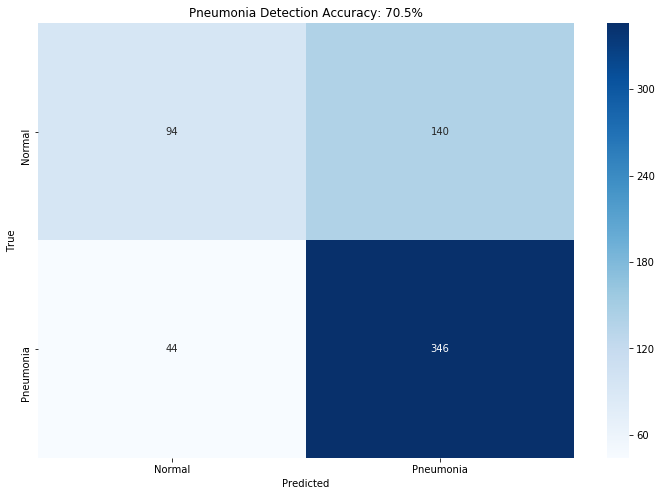

In [22]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

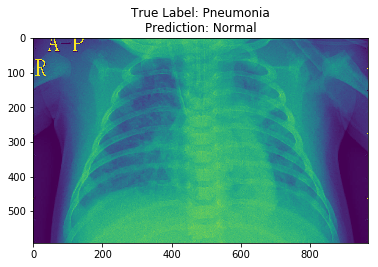

In [23]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)

